In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

randidx = np.random.permutation(10000)
devset = Subset(devtest,randidx[:5000])
testset = Subset(devtest,randidx[5000:])

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader = DataLoader(devset, batch_size=len(devset))
test_loader = DataLoader(testset, batch_size=len(testset))

In [12]:
print('Data shapes (train/dev/test):')
print(len(trainset))
print(len(devset))
print(len(testset))
print()

print('Data value range:')
print( (torch.min(trainset.data),torch.max(trainset.data)) )
print()

print('Data categories:')
print( trainset.classes )

Data shapes (train/dev/test):
60000
5000
5000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


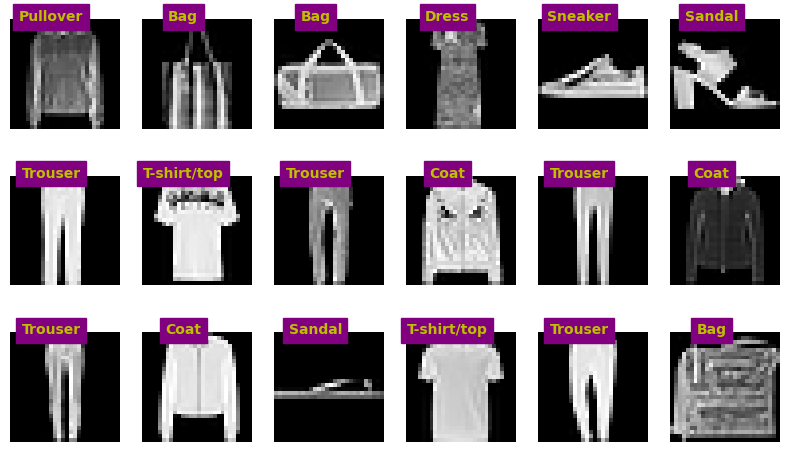

In [13]:
X,y = next(iter(test_loader))
fig,axs = plt.subplots(3,6,figsize=(8,5))

for (i,ax) in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5
  
  label = trainset.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(10,0,label,ha='center',fontweight='bold',color='y',backgroundcolor='purple')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
def create_model():

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1,16,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)

            self.conv2 = nn.Conv2d(16,32,3)
            self.bnorm2 = nn.BatchNorm2d(32)

            self.fc1 = nn.Linear(6*6*32,64)
            self.fc2 = nn.Linear(64,32)
            self.fc3 = nn.Linear(32,10)

        def forward(self, x):
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            
            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = self.fc3(x)
            return x
        
    model = Model()
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    return model, loss_fun, optimizer


In [34]:
def train_model():
    EPOCHS = 20
    model, loss_fun, optimizer = create_model()
    model.to(device)

    train_loss = torch.zeros(EPOCHS)
    dev_loss = torch.zeros(EPOCHS)
    train_acc = torch.zeros(EPOCHS)
    dev_acc = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        model.train()
        batch_loss = []
        batch_acc = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        
        train_loss[i] = np.mean(batch_loss)
        train_acc[i] = 100 * np.mean(batch_loss)

        model.eval()
        X, y = next(iter(dev_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            y_hat = model(X)
            loss = loss_fun(y_hat, y)

        dev_loss[i] = loss.item()
        dev_acc[i] = 100 * torch.mean((torch.argmax(y_hat, axis=1)==y).float()).item()

    return train_loss, dev_loss, train_acc, dev_acc, model    

In [35]:
train_loss, dev_loss, train_acc, dev_acc, model = train_model()

In [36]:
model.eval()
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

loss_fun = nn.CrossEntropyLoss()

with torch.inference_mode():
  yHat = model(X)
  loss = loss_fun(yHat,y)

# loss and accuracy from this batch
test_loss = loss.item()
test_acc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

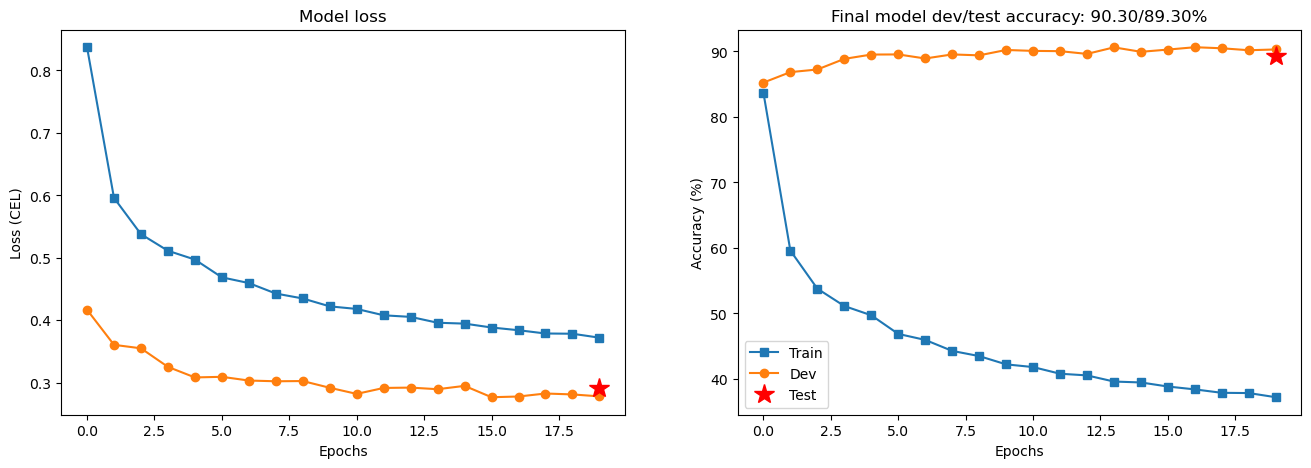

In [37]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(dev_loss,'o-',label='Dev')
ax[0].plot(len(dev_loss)-1,test_loss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(dev_acc,'o-',label='Dev')
ax[1].plot(len(dev_acc)-1,test_acc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {dev_acc[-1]:.2f}/{test_acc:.2f}%')
ax[1].legend()

plt.show()